# Libraries import

In [5]:
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.preprocessing import MinMaxScaler


In [6]:
import matplotlib.dates as mdates
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [7]:
df = pd.read_csv("AMZN.csv")


Date: The date of the trading day.

Open: The opening price of the stock on that day.

High: The highest price the stock reached during the trading day.

Low: The lowest price the stock reached during the trading day.

Close: The closing price of the stock on that day.

Adj Close: The adjusted closing price, which accounts for dividends, stock splits, and other adjustments.

Volume: The number of shares traded during the day.

In [23]:
pip install arch

   ---------------------------------------- 0.0/924.9 kB ? eta -:--:--
    -------------------------------------- 20.5/924.9 kB 682.7 kB/s eta 0:00:02
   ----------- ---------------------------- 266.2/924.9 kB 4.1 MB/s eta 0:00:01
   ---------------------------------------- 924.9/924.9 kB 8.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Exploratory Data analysis

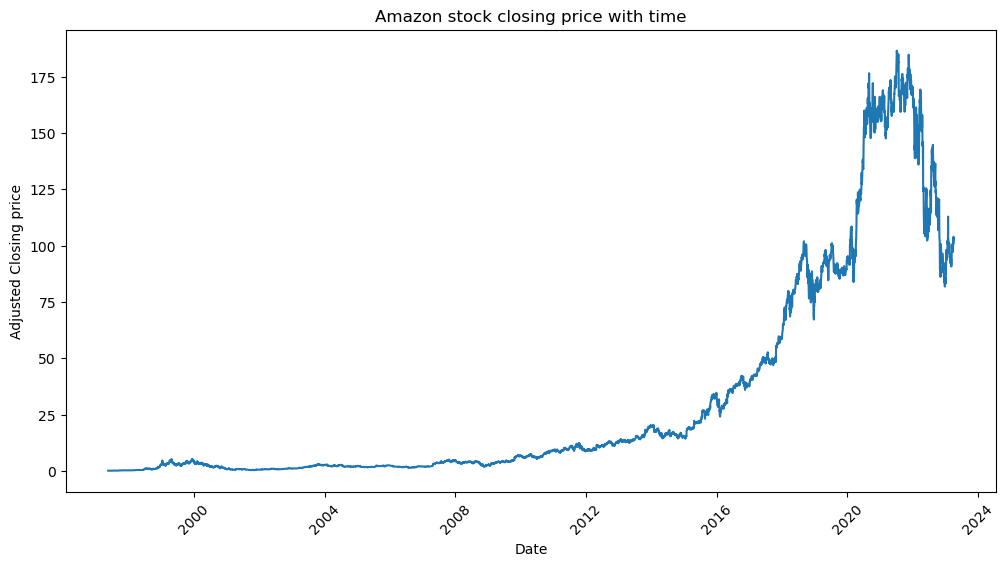

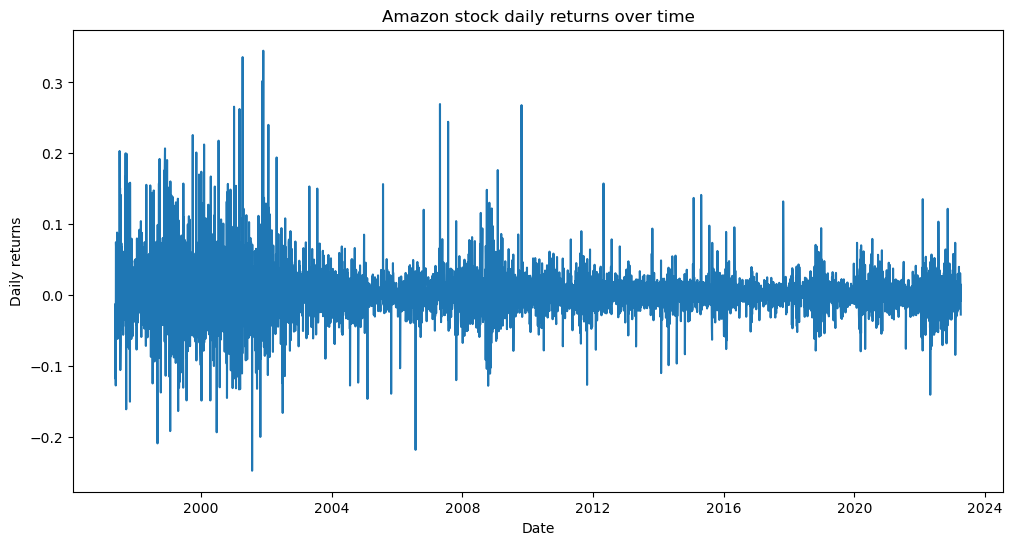

In [8]:
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Adj Close'])
plt.title("Amazon stock closing price with time")
plt.xlabel('Date')
plt.ylabel('Adjusted Closing price')
plt.xticks(rotation=45)

plt.show()

# percentage difference between the values in current row and previous row

df['Daily Return'] = df['Close'].pct_change()

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Daily Return'])
plt.title('Amazon stock daily returns over time')
plt.xlabel('Date')
plt.ylabel('Daily returns')
plt.show()

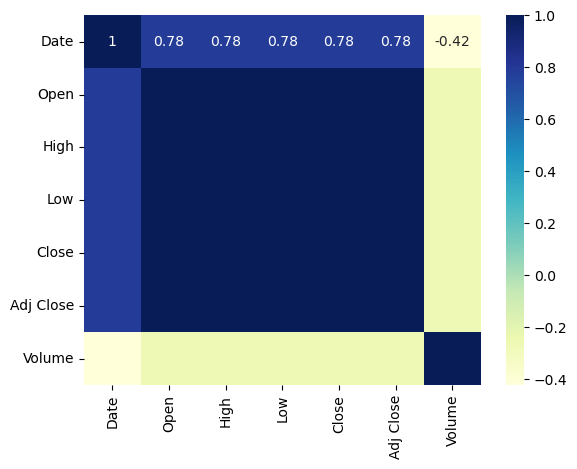

In [10]:
# Correlation Analysis:
# Analyze the correlation between different variables.
corr_matrix = df[['Date','Open','High','Low','Close','Adj Close','Volume']].corr()
dataplot = sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True) 
  
# displaying heatmap 
plt.show() 


C:\Users\sanja\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


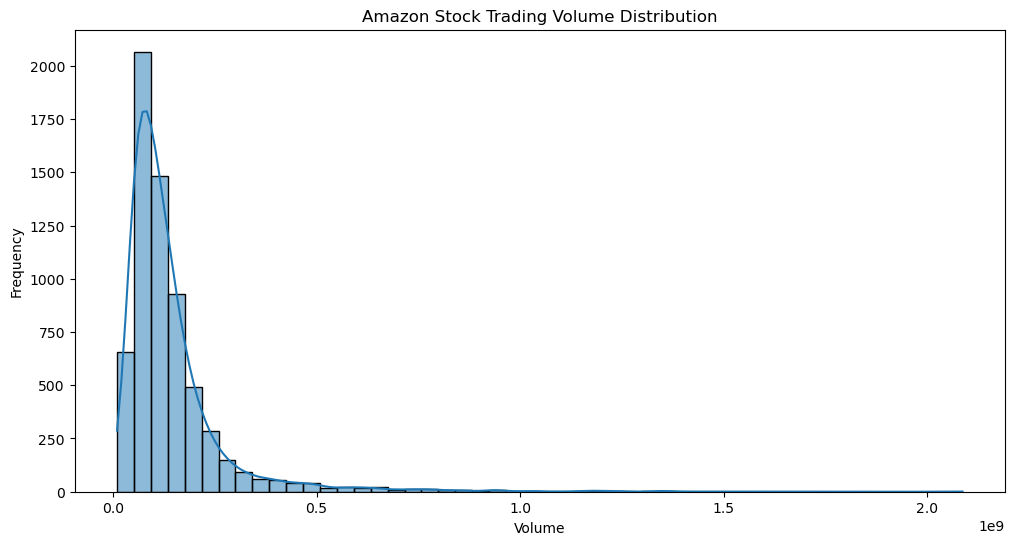

In [11]:
#Visualize volume by price range:
#Helps in understanding the trading volume distribution.

plt.figure(figsize=(12, 6))
sns.histplot(df['Volume'], bins=50, kde=True)
plt.title('Amazon Stock Trading Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

# Statistical analysis

# ARIMA / SARIMA

‘AutoRegressive Integrated Moving Average’, is a forecasting algorithm based on the idea that the information in
the past values of the time series can alone be used to predict the future values.

# parameters 

1) p => It represents the number of past values used to predict the current value.
2) q => This parameter indicates the number of times the raw observations are differenced to make the time series stationary.
        Differencing is used to remove trends and seasonality by subtracting the previous observation from the current   observation.
3) d => This parameter specifies the size of the moving average window (also called the order of the moving average).
        It represents the number of lagged forecast errors used to predict the current value.
        For example, if q=2, the model will use the previous two forecast errors in the prediction of the current value.

Since ARIMA model is a Univariate timeseries model, it will not use other independent variables to predict the dependent variable (in this case, Adj Close). It will use the past values of the variable "Adj Close" to predict the future values of "Adj Close"


In [12]:
# Check for stationarity and determine the value of "d"

def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'{key}: {value}')

check_stationarity(df['Adj Close'])

ADF Statistic: -0.44578758230603527
p-value: 0.9021686463445391
1%: -3.431359395451861
5%: -2.8619860660773804
10%: -2.5670074376517156


The p-value is much higher than 0.05 and the ADF statistic is also The ADF Statistic (-0.44578758230603527) is higher than all the critical values at 1%, 5%, and 10% levels, This further supports that we fail to reject the null hypothesis.
Since we fail to reject the null hypothesis, the timeseries points are not stationary. Inorder to make the points stationary, we differentiate the timeseries data points. 

ADF Statistic: -13.690631605249392
p-value: 1.3460788089744885e-25
1%: -3.4313597071653335
5%: -2.861986203804562
10%: -2.5670075109669024


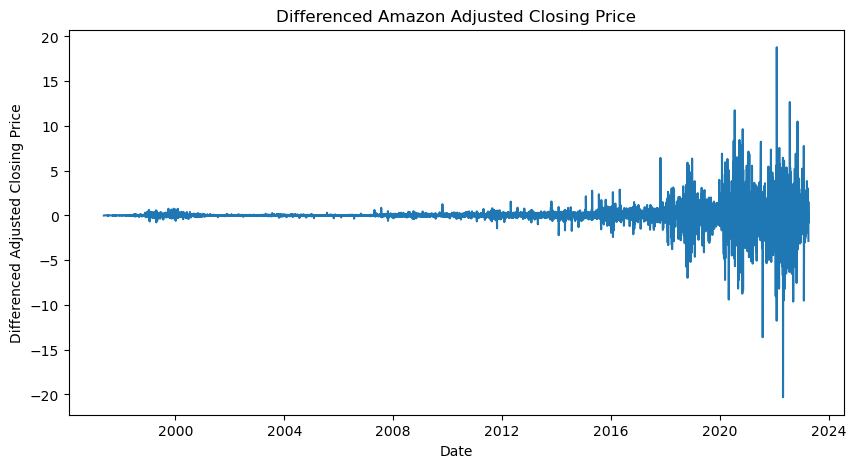

In [13]:
# Perform differencing
df['Adj Close Diff'] = df['Adj Close'].diff().dropna()

# Check for stationarity again
result = adfuller(df['Adj Close Diff'].dropna())

print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'{key}: {value}')

# Plot the differenced series
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Adj Close Diff'])
plt.title('Differenced Amazon Adjusted Closing Price')
plt.xlabel('Date')
plt.ylabel('Differenced Adjusted Closing Price')
plt.show()

We can calculate the correlation for time series observations with observations with previous time steps, called lags (the amount of time considered). 

Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a correlogram or an autocorrelation plot. 

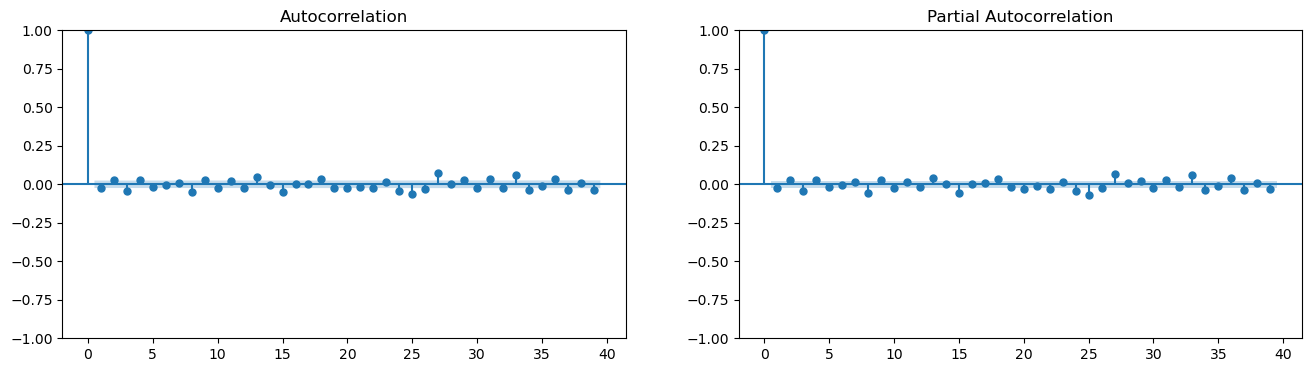

In [14]:
# Plot ACF and PACF for the differenced series. ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(df['Adj Close Diff'].dropna(), ax=axes[0])
plot_pacf(df['Adj Close Diff'].dropna(), ax=axes[1])
plt.show()

In [15]:
# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train, test = df['Adj Close'][:train_size], df['Adj Close'][train_size:]


In [16]:
# Fit the ARIMA model on the training data
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

# Make predictions
predictions = model_fit.forecast(steps=len(test))

# Calculate Mean Squared Error
mse = mean_squared_error(test, predictions)
print('Mean Squared Error:', mse)

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 5212
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -615.908
Date:                Wed, 24 Jul 2024   AIC                           1237.817
Time:                        17:58:31   BIC                           1257.492
Sample:                             0   HQIC                          1244.698
                               - 5212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1472      0.153     -0.961      0.337      -0.447       0.153
ma.L1          0.1950      0.151      1.289      0.198      -0.102       0.491
sigma2         0.0742      0.000    315.074      0.0

                                     SARIMAX Results                                      
Dep. Variable:                     Adj Close Diff   No. Observations:                 6516
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -10718.227
Date:                            Wed, 24 Jul 2024   AIC                          21446.453
Time:                                    18:00:52   BIC                          21480.353
Sample:                                         0   HQIC                         21458.178
                                           - 6516                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0202      0.004     -4.581      0.000      -0.029      -0.012
ma.L1         -0.9981      0.000  -

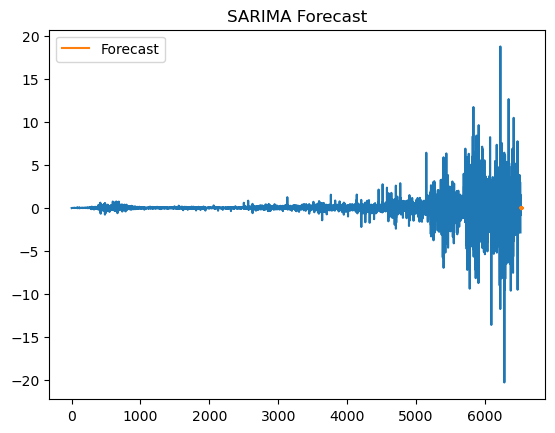

In [18]:
# Define the SARIMA order (p, d, q) and seasonal order (P, D, Q, s)
order = (1, 1, 1)  # ARIMA order
seasonal_order = (1, 1, 1, 12)  # Seasonal ARIMA order (monthly seasonality)

# Create a SARIMAX model
model = SARIMAX(df['Adj Close Diff'], order=order, seasonal_order=seasonal_order)

# Fit the model
results = model.fit()

# Print the summary of the model
print(results.summary())

# Forecast the next 30 days
forecast = results.forecast(steps=30)

# Plot the forecast
plt.plot(df['Adj Close Diff'])
plt.plot(forecast, label='Forecast')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

# Exponential smoothing

C:\Users\sanja\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


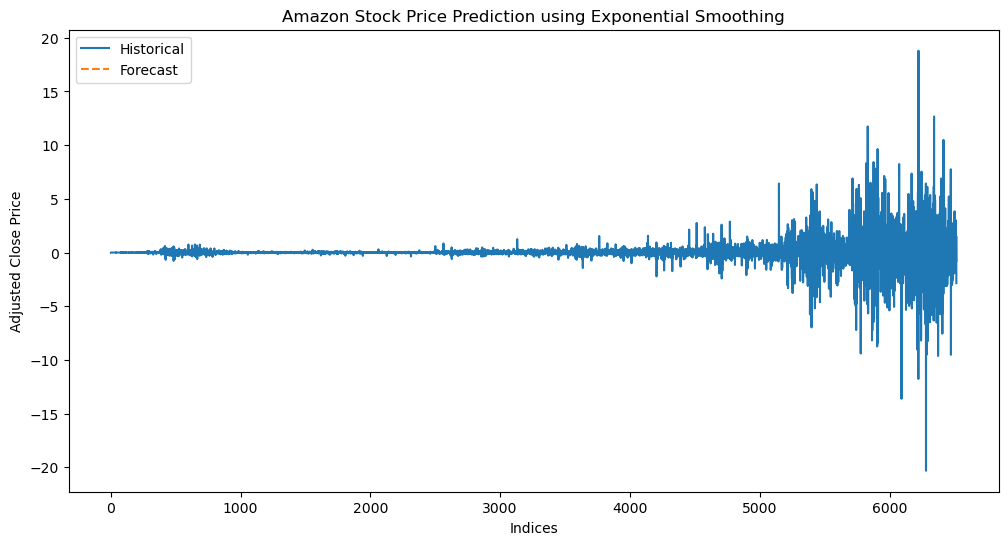

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit the Exponential Smoothing model
Adj_close = df['Adj Close Diff']
model = ExponentialSmoothing(Adj_close, trend='add', seasonal='add', seasonal_periods=252)  # 252 trading days in a year
fit = model.fit()

# Generate predictions
pred = fit.forecast(steps=252)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(Adj_close, label='Historical')
plt.plot(pred, label='Forecast', linestyle='--')
plt.title('Amazon Stock Price Prediction using Exponential Smoothing')
plt.xlabel('Indices')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Long Short Term Memory

In [48]:
#Set Target Variable
output_var = pd.DataFrame(df['Adj Close'])
#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

In [49]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
0,0.000276,0.000279,0.000166,0.690172
1,0.000150,0.000141,0.000107,0.136869
2,0.000095,0.000086,0.000085,0.054117
3,0.000086,0.000080,0.000087,0.047957
4,0.000061,0.000052,0.000017,0.176865


In [50]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [51]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [53]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


C:\Users\sanja\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [54]:
#Model Training
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 31.0703
Epoch 2/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 250.4101
Epoch 3/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 198.1904
Epoch 4/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 118.9608
Epoch 5/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 63.1090
Epoch 6/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 29.7898
Epoch 7/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13.0902
Epoch 8/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.4779
Epoch 9/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.2820
Epoch 10/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.5739
Epoch 11/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.3864
Epoch 12/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4238
Epoch 13/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.5622
Epoch 14/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7270
Epoch 15/100
741/741 ━━━━━━━━━━━━

741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0683
Epoch 81/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0630
Epoch 82/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0585
Epoch 83/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0547
Epoch 84/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0513
Epoch 85/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0483
Epoch 86/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0458
Epoch 87/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0435
Epoch 88/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0415
Epoch 89/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0397
Epoch 90/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0382
Epoch 91/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0368
Epoch 92/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0357
Epoch 93/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0347
Epoch 94/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1m

In [55]:
#LSTM Prediction
y_pred= lstm.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


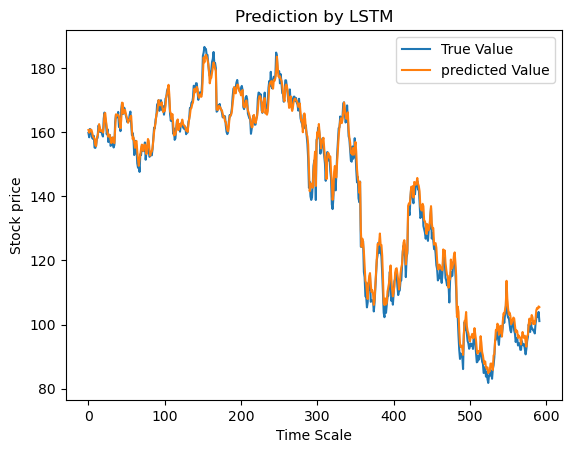

In [58]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='predicted Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Stock price')
plt.legend()
plt.show()